In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import linregress
import matplotlib as mpl
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

pd.options.mode.chained_assignment = None
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 13  

# Now you can import hrdtimer
from hrdtimer import MolecularTimeToAge

In [41]:
NormalTissue = pd.read_csv("/Volumes/extSSD/park_lab/HRDTimer_Analysis/AAA_Apr25_plots/data/NormalTissue_SBS1_Age_plot.csv", index_col=0)
BulkTumor =  pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/PCAWG_SCANB_INFORM_SBS1_Age_plot.csv", index_col=0)
PCAWG_HRDTimer = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/PCAWG_Breast_WGD_HRD_TimingResults_timing_nboot200_0001.csv")
SCANB_HRDTimer = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/SCANB_unfiltered_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv")
INFORM_HRDTimer = pd.read_csv("/Volumes/extSSD/park_lab/HRDTimer_Analysis/INFORM_germline_filtered_Breast_WGD_HRD_TimingResults_v9_timing_nboot200.csv")

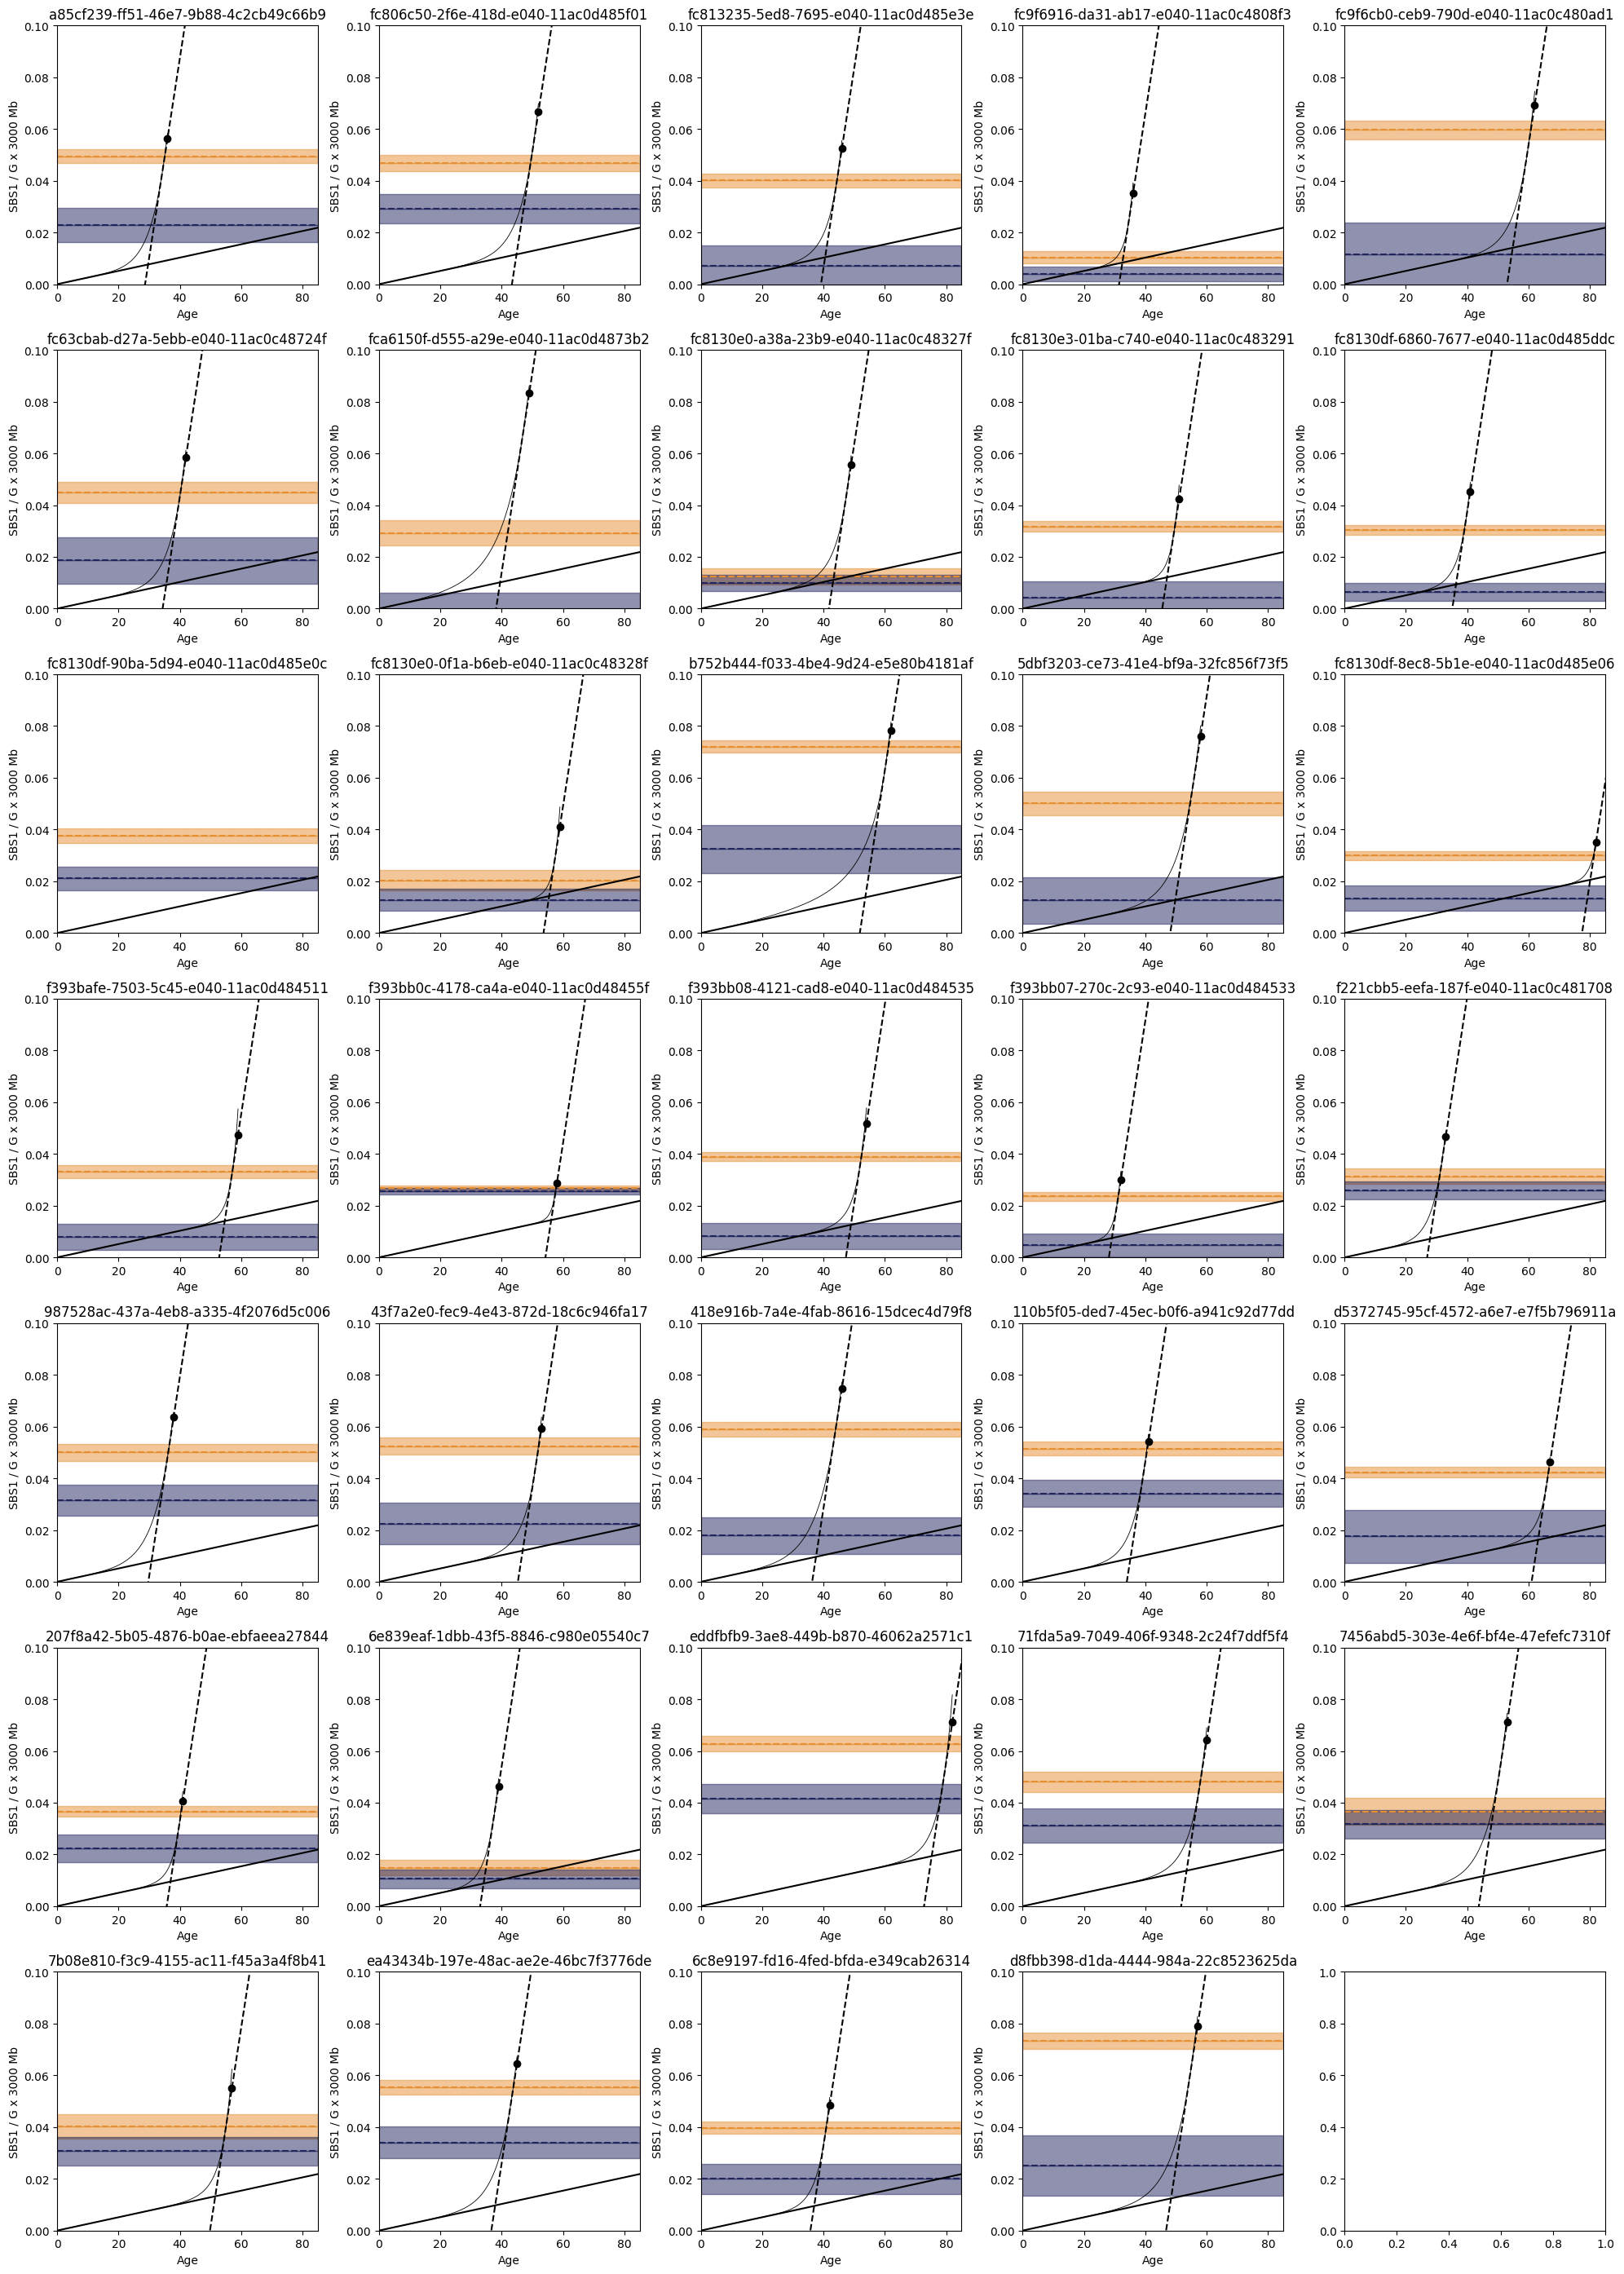

In [ ]:
# PCAWG
MolecularTimeToAge.analyze_cohort_timing(
    cohort_name="PCAWG",
    bulk_tumor_df=BulkTumor,
    hrd_timer_df=PCAWG_HRDTimer,
    normal_tissue_df=NormalTissue,
    output_csv="MC_to_Age_results_PCAWG.csv",
    output_fig="Age_results_PCAWG.pdf"
)

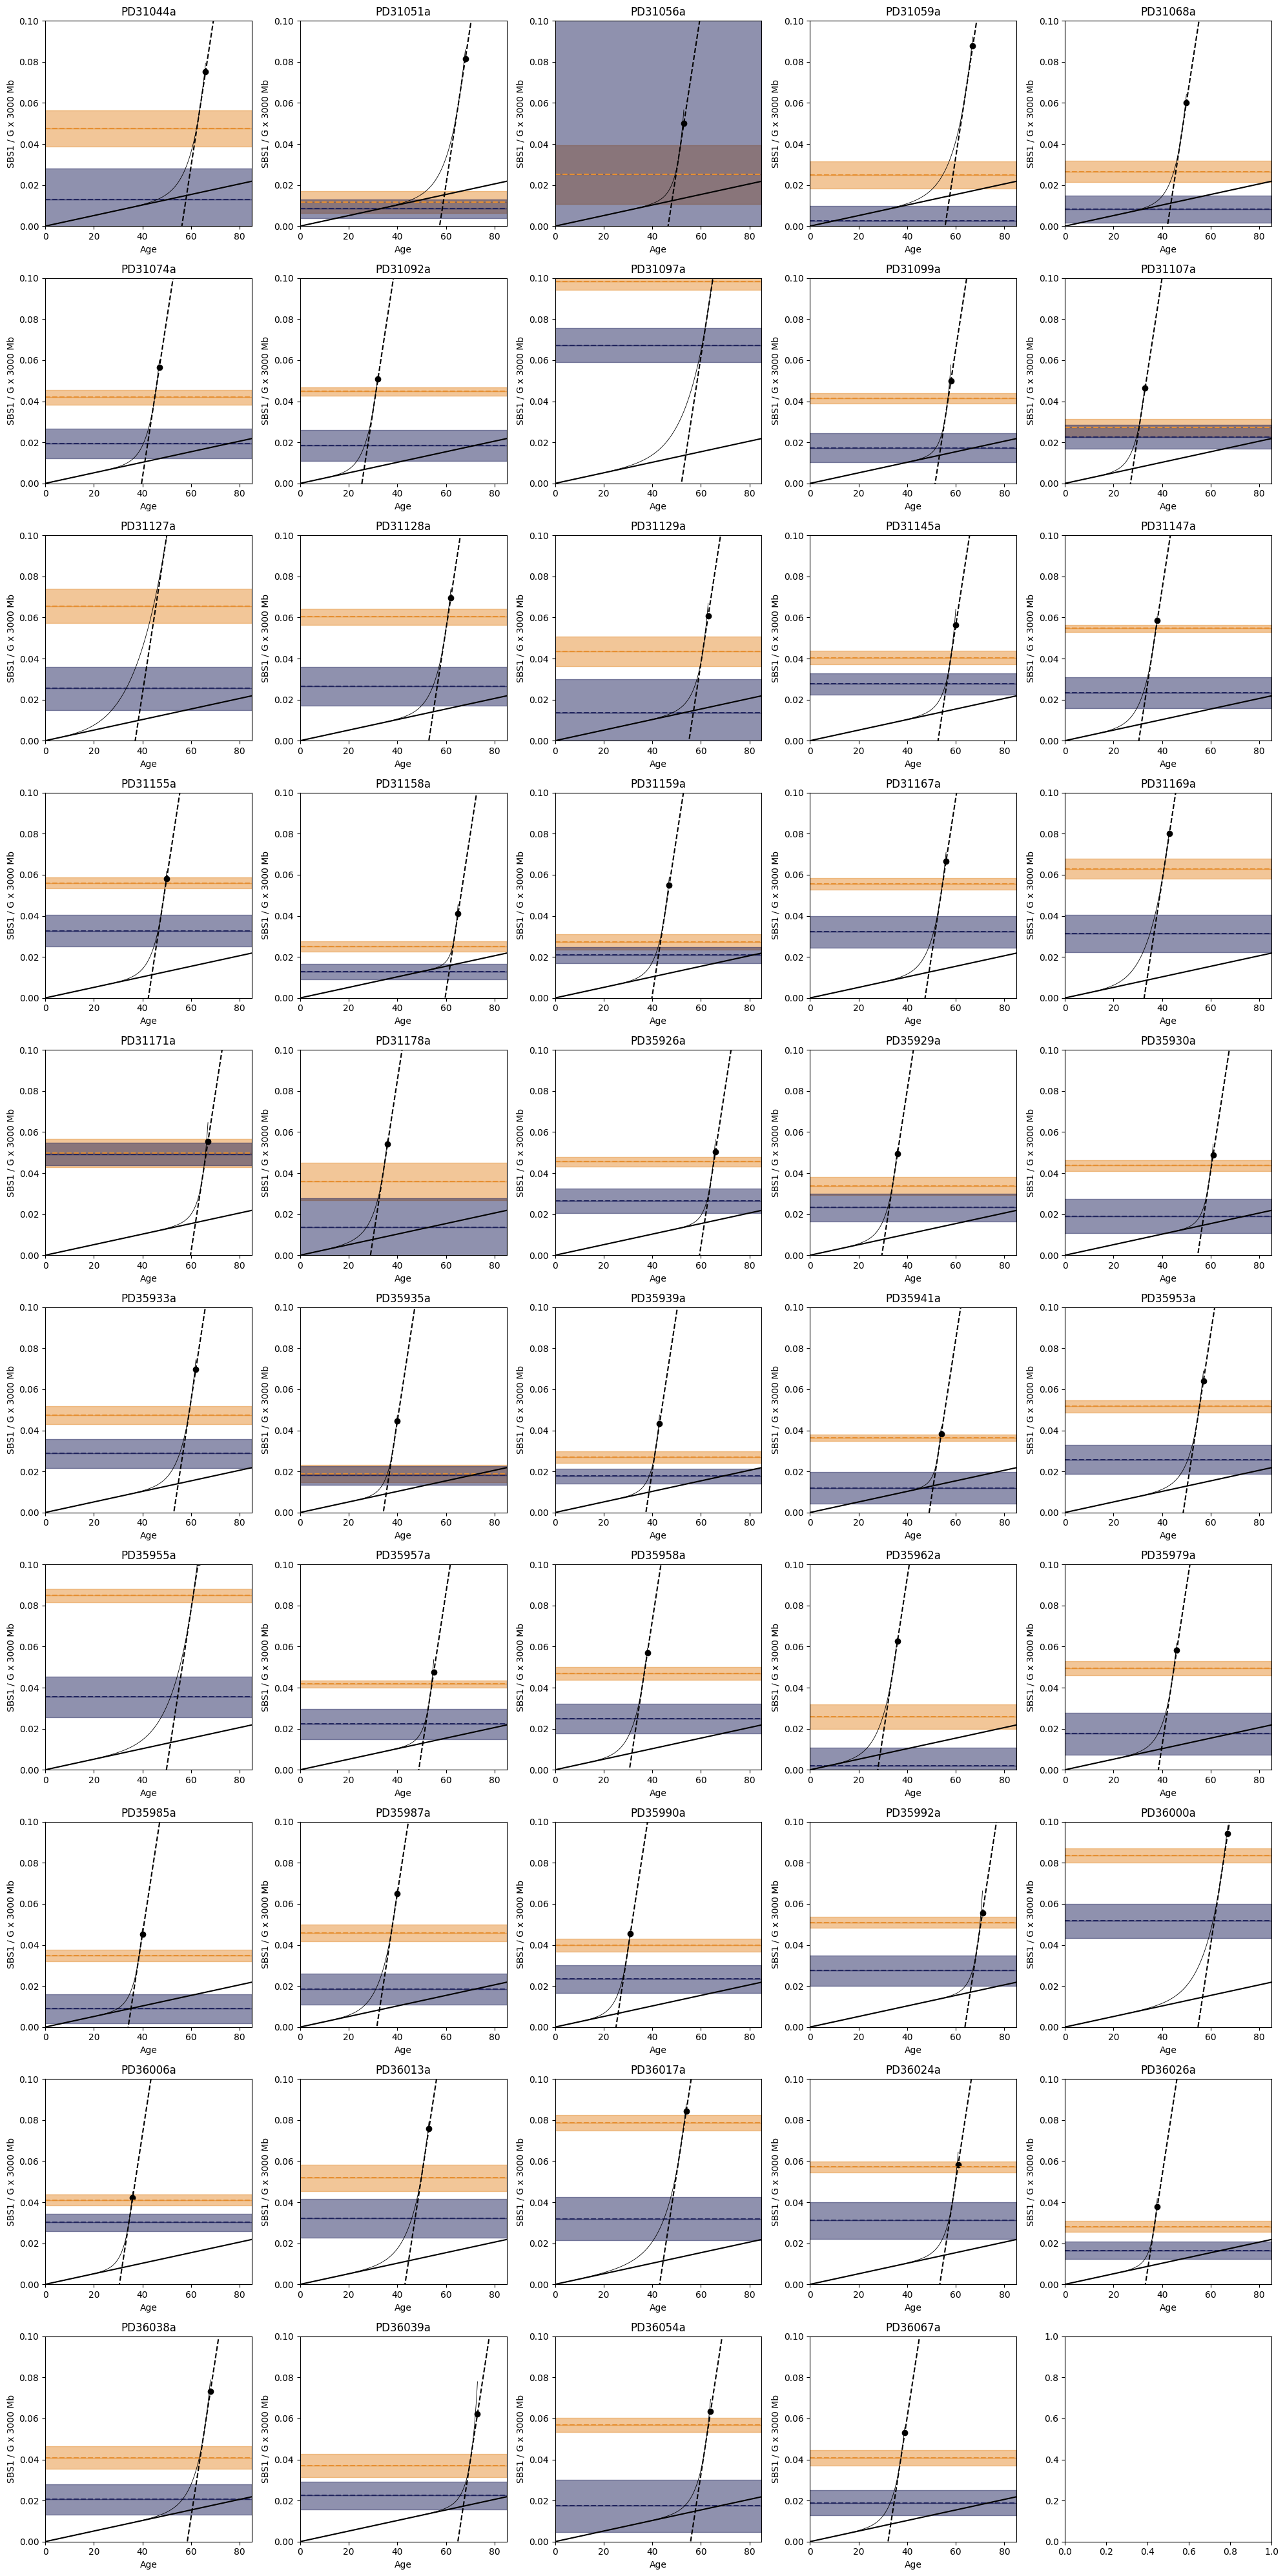

In [ ]:
# SCANB
MolecularTimeToAge.analyze_cohort_timing(
    cohort_name="SCANB",
    bulk_tumor_df=BulkTumor,
    hrd_timer_df=SCANB_HRDTimer,
    normal_tissue_df=NormalTissue,
    output_csv="MC_to_Age_results_SCANB.csv",
    output_fig="Age_results_SCANB.pdf"
)

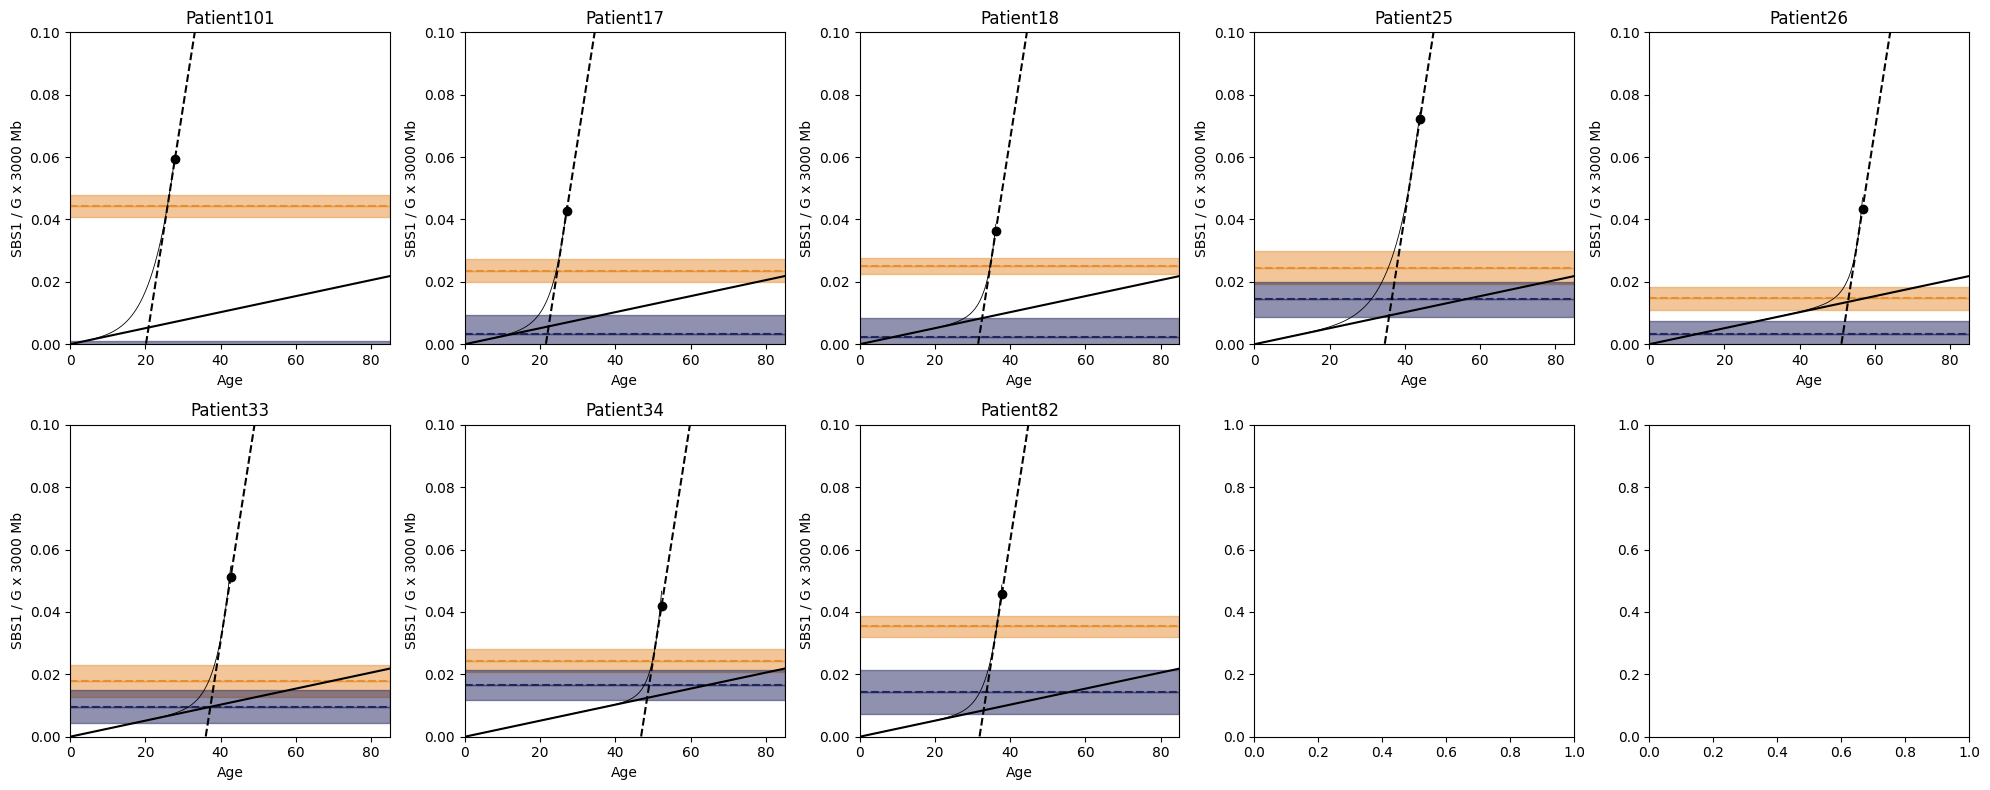

In [ ]:
# INFORM
MolecularTimeToAge.analyze_cohort_timing(
    cohort_name="INFORM",
    bulk_tumor_df=BulkTumor,
    hrd_timer_df=INFORM_HRDTimer,
    normal_tissue_df=NormalTissue,
    output_csv="MC_to_Age_results_INFORM.csv",
    output_fig="Age_results_INFORM.pdf"
)

# HRD lag figure

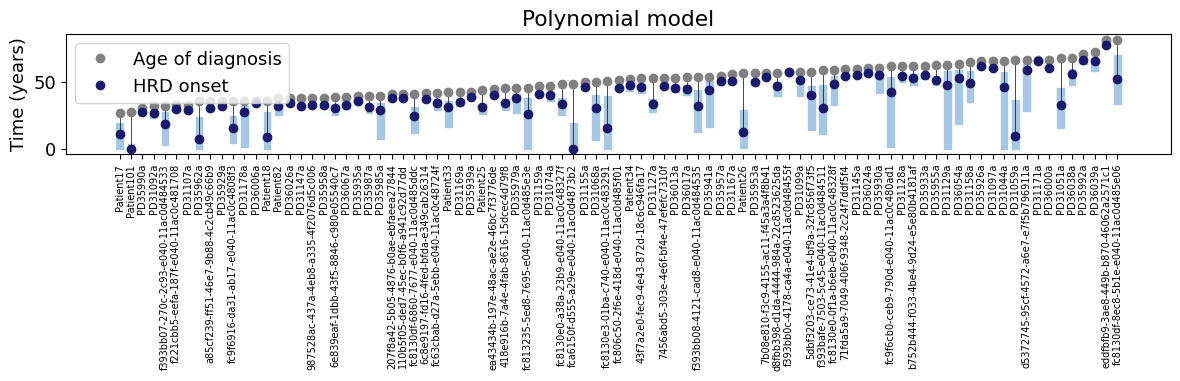

In [36]:
dfs = []
for name in ["INFORM", "PCAWG", "SCANB"]:
    df = pd.read_csv(f"/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/MC_to_Age_results_{name}.csv")
    df['Cohort'] = name
    df.replace("NA", pd.NA, inplace=True)
    df.dropna(subset=['HRD', 'HRD_low', 'HRD_high'], how='all', inplace=True)
    df.fillna(0, inplace=True)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True).astype({'Age': float, 'HRD': float, 'HRD_low': float, 'HRD_high': float})
df = df.sort_values(by='Age').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 4))
color = '#A7C7E7'

for i, row in df.iterrows():
    ax.plot([i, i], [row['Age'], row['HRD']], color='k', lw=0.5, zorder=1)
    ax.add_patch(plt.Rectangle((i - 0.3, row['HRD_low']), 0.6, row['HRD_high'] - row['HRD_low'], color=color, alpha=1, zorder=0))
    ax.plot(i, row['Age'], 'o', color='grey', label='Age of diagnosis' if i == 0 else "", zorder=2)
    ax.plot(i, row['HRD'], 'o', color='#191970', label='HRD onset' if i == 0 else "", zorder=3)

ax.set_xticks(range(len(df)))
ax.set_xticklabels(df['ID'], rotation=90, fontsize=7)
ax.set_ylabel("Time (years)")
ax.set_title("Polynomial model")

handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys(), loc='upper left')

plt.tight_layout()
#plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/Polynomial.pdf", format='pdf', bbox_inches='tight')
plt.show()


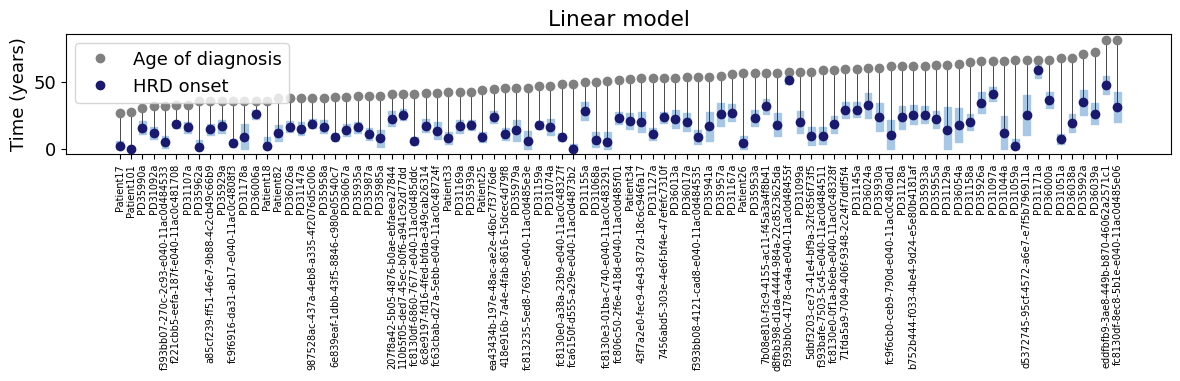

In [37]:
dfs = []
for name in ["INFORM", "PCAWG", "SCANB"]:
    df = pd.read_csv(f"/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/MC_to_Age_results_{name}.csv")
    df['Cohort'] = name
    df.replace("NA", pd.NA, inplace=True)
    df.dropna(subset=['HRD', 'HRD_low', 'HRD_high'], how='all', inplace=True)
    df.fillna(0, inplace=True)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True).astype({'Age': float, 'HRD_linear': float, 'HRD_linear_low': float, 'HRD_linear_high': float})
df = df.sort_values(by='Age').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 4))
color = '#A7C7E7'


for i, row in df.iterrows():
    ax.plot([i, i], [row['Age'], row['HRD_linear']], color='k', lw=0.5, zorder=1)
    ax.add_patch(plt.Rectangle((i - 0.3, row['HRD_linear_low']), 0.6, row['HRD_linear_high'] - row['HRD_linear_low'], color=color, alpha=1, zorder=0))
    ax.plot(i, row['Age'], 'o', color='grey', label='Age of diagnosis' if i == 0 else "", zorder=2)
    ax.plot(i, row['HRD_linear'], 'o', color='#191970', label='HRD onset' if i == 0 else "", zorder=3)

ax.set_xticks(range(len(df)))
ax.set_xticklabels(df['ID'], rotation=90, fontsize=7)
ax.set_ylabel("Time (years)")
ax.set_title("Linear model")

handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys(), loc='upper left')

plt.tight_layout()
#plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/Linear.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [38]:
sample_order = [x.get_text() for x in ax.get_xticklabels()]

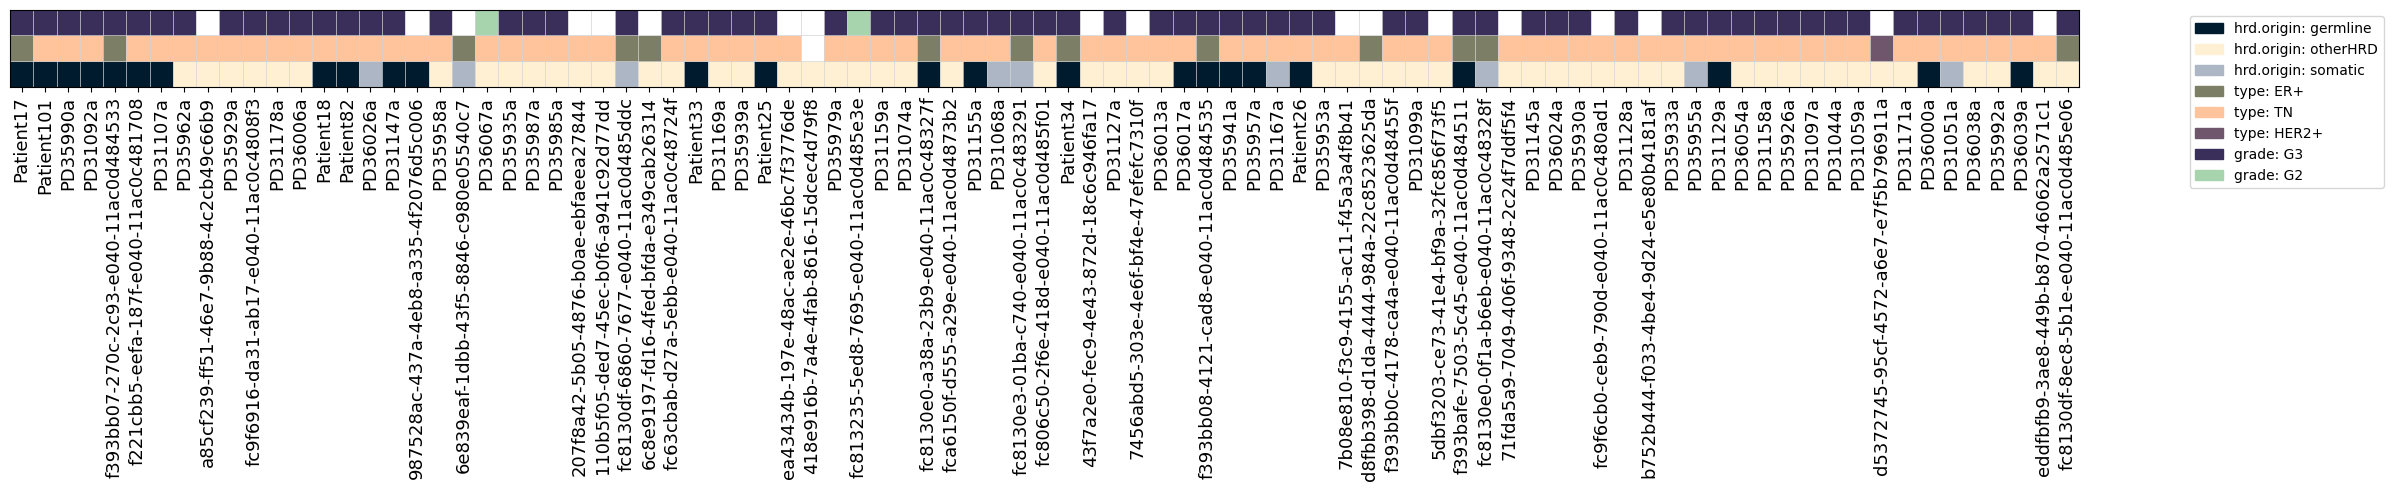

In [7]:
metadata = pd.read_csv("pan_metadata_v3.csv").set_index("sample").loc[sample_order]
annotations, offsets = ['hrd.origin', 'type', 'grade'], [0.5, 1.5, 2.5, 3.5]
row_colors = {'hrd.origin': ['#001B2E', '#FFEFD3', '#ADB6C4', 'grey'], 'type': ['#7C7F65', '#FFC49B', '#70566D'], 'grade': ['#392F5A', '#A8D4AD', 'brown']}

fig, ax = plt.subplots(figsize=(len(sample_order) * 0.3, 1))
ax.set_xticks(range(len(sample_order)))
ax.set_xticklabels(sample_order, rotation=90)

for i, sample in enumerate(sample_order):
    for j, col in enumerate(annotations):
        val = metadata.at[sample, col]
        color = row_colors[col][list(metadata[col].dropna().unique()).index(val)] if pd.notna(val) else "white"
        ax.add_patch(patches.Rectangle((i - 0.5, offsets[j]), 1, 1, color=color, linewidth=0.5))

for i in range(len(sample_order) + 1): ax.axvline(x=i - 0.5, color='lightgrey', linewidth=0.5)
for j in offsets: ax.axhline(y=j, color='lightgrey', linewidth=0.5)

ax.set_yticks([])

patches_list = [patches.Patch(color=row_colors[col][idx], label=f'{col}: {val}') for col in annotations for idx, val in enumerate(metadata[col].dropna().unique())]
ax.legend(handles=patches_list, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

ax.set_ylim(0.5, offsets[-1])
ax.set_xlim(-0.5, len(sample_order) - 0.5)
plt.savefig("/Volumes/extSSD/park_lab/HRDTimer_Analysis/AAA_Apr25_plots/meta_hrdlag.pdf", format='pdf', bbox_inches='tight')
plt.show()


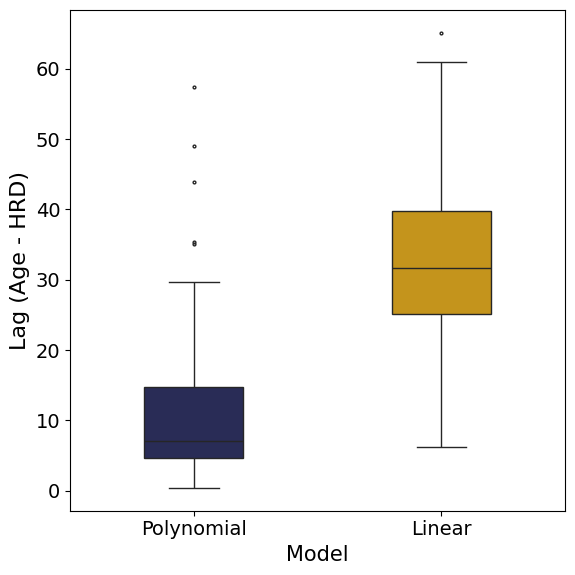

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

df_poly, df_linear = [], []
for name in ["INFORM", "PCAWG", "SCANB"]:
    df = pd.read_csv(f"MC_to_Age_results_{name}.csv")
    df['Cohort'] = name
    df.replace("NA", pd.NA, inplace=True)
    df.dropna(subset=['HRD', 'HRD_low', 'HRD_high'], how='all', inplace=True)
    df.fillna(0, inplace=True)
    df_poly.append(df)
    df_linear.append(df.astype({
        'Age': float, 'HRD_linear': float, 
        'HRD_linear_low': float, 'HRD_linear_high': float
    }))

df_poly = pd.concat(df_poly).sort_values('Age').reset_index(drop=True)
df_linear = pd.concat(df_linear).sort_values('Age').reset_index(drop=True)

df_poly['lag'] = df_poly['Age'] - df_poly['HRD']
df_linear['lag'] = df_linear['Age'] - df_linear['HRD_linear']
df_poly['Model'], df_linear['Model'] = 'Polynomial', 'Linear'

df_all = pd.concat([df_poly[['lag','Model']], df_linear[['lag','Model']]])

stat, p = mannwhitneyu(df_poly['lag'], df_linear['lag'])

plt.figure(figsize=(6,6))
sns.boxplot(
    data=df_all, x='Model', hue='Model', y='lag', 
    palette=["#21255e", "#e0a000"], 
    width=0.4, fliersize=2, linewidth=1,
    legend=False
)
plt.ylabel('Lag (Age - HRD)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("/Volumes/extSSD/park_lab/HRDTimer_Analysis/AAA_Apr25_plots/lin_pol_boxplot.pdf", format='pdf', bbox_inches='tight')
plt.show()


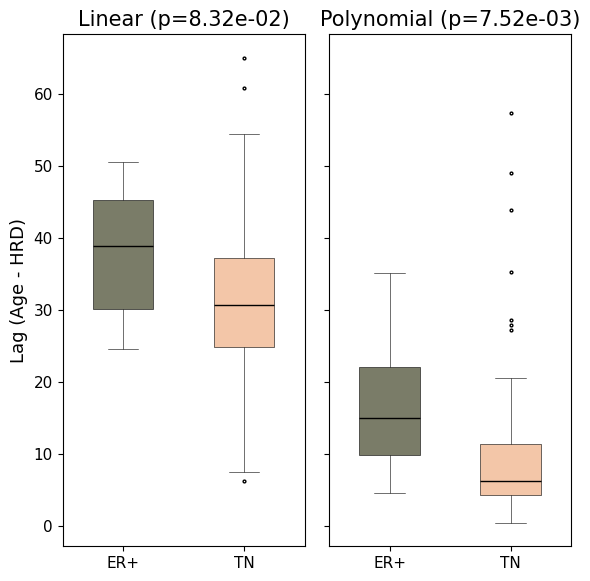

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

metadata = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/metadata/pan_metadata_v3.csv").set_index("sample")

def load_lag_data(model):
    dfs = []
    for name in ["INFORM", "PCAWG", "SCANB"]:
        df = pd.read_csv(f"/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/MC_to_Age_results_{name}.csv")
        df['Cohort'] = name
        df.replace("NA", pd.NA, inplace=True)
        df.dropna(subset=['HRD', 'HRD_low', 'HRD_high'], how='all', inplace=True)
        df.fillna(0, inplace=True)
        dfs.append(df)
    df_all = pd.concat(dfs).sort_values('Age').reset_index(drop=True)
    if model == "Polynomial":
        df_all['lag'] = df_all['Age'] - df_all['HRD']
    else:
        df_all = df_all.astype({'Age': float, 'HRD_linear': float})
        df_all['lag'] = df_all['Age'] - df_all['HRD_linear']
    df_all['Model'] = model
    return df_all

df_poly = load_lag_data("Polynomial")
df_linear = load_lag_data("Linear")

combined = pd.concat([df_poly[['ID', 'lag', 'Model']], df_linear[['ID', 'lag', 'Model']]])
combined = combined.set_index('ID').join(metadata[['type']]).reset_index()
combined = combined[combined['type'].isin(['ER+', 'TN'])]

fig, axes = plt.subplots(1, 2, figsize=(6, 6), sharey=True)

# Linear on the left, Polynomial on the right
for i, model in enumerate(['Linear', 'Polynomial']):
    df_model = combined[combined['Model'] == model]
    er_lag = df_model[df_model['type'] == 'ER+']['lag']
    tn_lag = df_model[df_model['type'] == 'TN']['lag']
    p = mannwhitneyu(er_lag, tn_lag, alternative='two-sided').pvalue
    sns.boxplot(data=df_model, x='type', hue='type', y='lag',
                order=['ER+', 'TN'],  # ensures ER+ is on the left
                palette={'ER+': '#7C7F65', 'TN': '#FFC49B'},
                ax=axes[i], width=0.5, fliersize=2, legend=False,
                boxprops=dict(edgecolor='black', linewidth=0.4),
                whiskerprops=dict(color='black', linewidth=0.4),
                capprops=dict(color='black', linewidth=0.4),
                medianprops=dict(color='black'),
                flierprops=dict(markeredgecolor='black', linewidth=0.5))
    axes[i].set_title(f'{model} (p={p:.2e})', fontsize=15)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Lag (Age - HRD)', fontsize=13)
    axes[i].tick_params(labelsize=11)

plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/hrdlag_type.pdf", format='pdf', bbox_inches='tight')
plt.show()


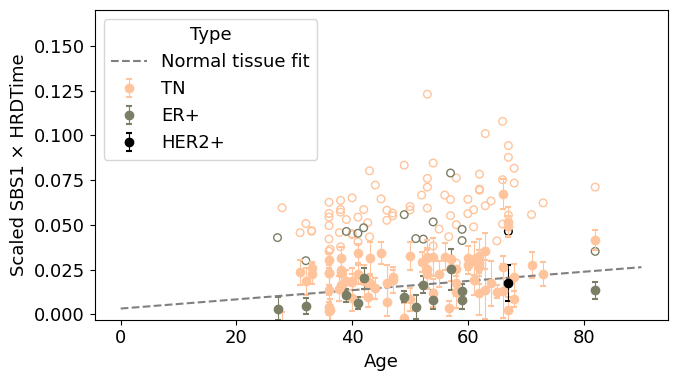

In [42]:
# Load and filter data
metadata = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/metadata/pan_metadata_v3.csv").set_index("sample")
BulkTumor = BulkTumor[BulkTumor['aliquot_id'].isin(sample_order)]

# Cohort-specific HRD timing data
cohorts = {"PCAWG": PCAWG_HRDTimer, "SCANB": SCANB_HRDTimer, "INFORM": INFORM_HRDTimer}
colors = {'ER+': '#7C7F65', 'TN': '#FFC49B', 'HER2+': 'black'}

# Merge cohort data with metadata
merged_data = [pd.merge(BulkTumor[BulkTumor['Cohort'] == cohort], hrd, left_on='aliquot_id', right_on='ID')
               .drop(columns='ID').set_index('aliquot_id').join(metadata[['type']])
               for cohort, hrd in cohorts.items()]
full_data = pd.concat(merged_data)

# x = age, y = scaled_SBS1 * HRDTime, yerr = scaled_SBS1 * HRDTime_ci
x, y, yerr, type_values = full_data['age'], full_data['scaled_SBS1'] * full_data['HRDTime'], \
                          full_data['scaled_SBS1'] * full_data['HRDTime_ci'], full_data['type']

# Plot
fig, ax = plt.subplots(figsize=(7, 4))
for t in ['TN', 'ER+', 'HER2+']:
    subset = full_data[type_values == t]
    plt.errorbar(subset['age'], subset['scaled_SBS1'] * subset['HRDTime'], 
                 yerr=subset['scaled_SBS1'] * subset['HRDTime_ci'], fmt='o', 
                 color=colors[t], label=t, alpha=1, elinewidth=0.8, capsize=2, capthick=1.5)
    plt.scatter(subset['age'], subset['scaled_SBS1'], color=colors[t], 
                edgecolor=colors[t], facecolors='none', s=30, alpha=1)

# Normal tissue regression
x_norm, y_norm = NormalTissue['age'], NormalTissue['scaled_SBS1']
slope_norm, intercept_norm, *_ = linregress(x_norm, y_norm)
plt.plot(np.linspace(0, 90, 1000), slope_norm * np.linspace(0, 90, 1000) + intercept_norm, 
         label='Normal tissue fit', color='gray', linestyle='--')
plt.xlabel("Age")
plt.ylabel("Scaled SBS1 × HRDTime")
plt.legend(title="Type")
plt.tight_layout()
plt.ylim(-0.003, 0.17)
#plt.savefig("/Volumes/extSSD/park_lab/HRDTimer_Analysis/AAA_Apr25_plots/hrd_ScaledSBS1.pdf", format='pdf', bbox_inches='tight')
plt.show()


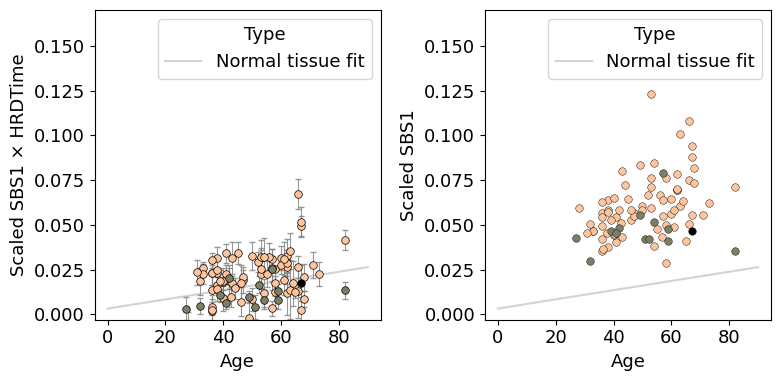

In [59]:
# Load and filter data
metadata = pd.read_csv("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/metadata/pan_metadata_v3.csv").set_index("sample")
BulkTumor = BulkTumor[BulkTumor['aliquot_id'].isin(sample_order)]

# Cohort-specific HRD timing data
cohorts = {"PCAWG": PCAWG_HRDTimer, "SCANB": SCANB_HRDTimer, "INFORM": INFORM_HRDTimer}
colors = {'ER+': '#7C7F65', 'TN': '#FFC49B', 'HER2+': 'black'}

# Merge cohort data with metadata
merged_data = [pd.merge(BulkTumor[BulkTumor['Cohort'] == cohort], hrd, left_on='aliquot_id', right_on='ID')
               .drop(columns='ID').set_index('aliquot_id').join(metadata[['type']])
               for cohort, hrd in cohorts.items()]
full_data = pd.concat(merged_data)

# x = age, y = scaled_SBS1 * HRDTime, yerr = scaled_SBS1 * HRDTime_ci
x, y, yerr, type_values = full_data['age'], full_data['scaled_SBS1'] * full_data['HRDTime'], \
                          full_data['scaled_SBS1'] * full_data['HRDTime_ci'], full_data['type']

# Set up side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

# Plot 1: scaled_SBS1 * HRDTime with error bars and black-bordered markers
for t in ['TN', 'ER+', 'HER2+']:
    subset = full_data[type_values == t]
    # Plot error bars only
    ax1.errorbar(subset['age'], subset['scaled_SBS1'] * subset['HRDTime'], 
                 yerr=subset['scaled_SBS1'] * subset['HRDTime_ci'], fmt='none',
                 ecolor='grey', alpha=0.8, elinewidth=0.8, capsize=2, capthick=1.0, zorder=1)
    # Plot markers with black border
    ax1.scatter(subset['age'], subset['scaled_SBS1'] * subset['HRDTime'],
                facecolor=colors[t], edgecolor='black', s=30, alpha=1, linewidth=0.5, zorder=2)

# Regression line from normal tissue
x_norm, y_norm = NormalTissue['age'], NormalTissue['scaled_SBS1']
slope_norm, intercept_norm, *_ = linregress(x_norm, y_norm)
x_fit = np.linspace(0, 90, 1000)
y_fit = slope_norm * x_fit + intercept_norm
ax1.plot(x_fit, y_fit, '-', color='lightgray', label='Normal tissue fit', zorder=0)
ax1.set_xlabel("Age")
ax1.set_ylabel("Scaled SBS1 × HRDTime")
ax1.legend(title="Type")
ax1.set_ylim(-0.003, 0.17)

# Plot 2: raw scaled_SBS1 values (also with black border)
for t in ['TN', 'ER+', 'HER2+']:
    subset = full_data[type_values == t]
    ax2.scatter(subset['age'], subset['scaled_SBS1'],
                facecolor=colors[t], edgecolor='black', s=30, alpha=1, linewidth=0.3)

# Regression line for normal tissue
ax2.plot(x_fit, y_fit, '-', color='lightgray', label='Normal tissue fit')
ax2.set_xlabel("Age")
ax2.set_ylabel("Scaled SBS1")
ax2.legend(title="Type")
ax2.set_ylim(-0.003, 0.17)

plt.tight_layout()
plt.savefig("/Users/michail/HMS Dropbox/Michail Andreopoulos/HRDTimer/data/output/output_plots/hrd_ScaledSBS1.pdf", format='pdf', bbox_inches='tight')
plt.show()

